<a href="https://colab.research.google.com/github/christiangarza1505813/Tesina/blob/main/Model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install pandas pyarrow scikit-learn joblib

import io, os, textwrap, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error


In [2]:
CSV_URL = "https://raw.githubusercontent.com/christiangarza1505813/Tesina/main/Datos/user_clasification.csv"  # <-- reemplaza

df = pd.read_csv(
    CSV_URL,
)

In [3]:
df['YMD'] = pd.to_datetime(df['YMD'])
df_sorted = df.sort_values(by=['AccountUuid', 'YMD'])
df = df_sorted.drop_duplicates(subset=['AccountUuid'], keep='first')
df.describe()

,YMD,Plaid,Issued_Card,Transacting,Pmt_method,YearOfBirth,postal_code,lat,lng,density
count,67678,67678.000000,67678.000000,67678.000000,67678.000000,67678.000000,67678.000000,67678.000000,67678.000000,67678.000000
mean,2024-06-23 07:05:41.605839104,0.042362,0.608839,0.313810,0.132672,1988.604968,64218.323680,35.987574,-98.183960,1668.881913
min,2022-08-08 00:00:00,0.000000,0.000000,0.000000,0.000000,1900.000000,10002.000000,19.306120,-166.471250,0.000000
25%,2023-12-25 06:00:00,0.000000,0.000000,0.000000,0.000000,1983.000000,37241.250000,32.934170,-115.123130,144.700000
50%,2024-05-09 00:00:00,0.000000,1.000000,0.000000,0.000000,1990.000000,75141.000000,35.249220,-95.870100,821.300000
75%,2024-12-30 00:00:00,0.000000,1.000000,1.000000,0.000000,1996.000000,89104.000000,39.723890,-84.549560,1931.500000
max,2025-09-13 00:00:00,1.000000,1.000000,1.000000,1.000000,2007.000000,99901.000000,67.254350,-72.372230,58289.600000
std,NaN,0.201416,0.488014,0.464043,0.339223,10.402508,26328.559487,4.846153,15.499654,3232.997743


#Calidad de los datos


##% de nulos

In [4]:

obj_cols = df.select_dtypes(include=['object', 'string']).columns

# Máscaras de vacíos y nulos
mask_empty = pd.DataFrame(False, index=df.index, columns=df.columns)
if len(obj_cols):
    mask_empty[obj_cols] = df[obj_cols].astype('string').apply(lambda s: s.str.strip().eq(''))

mask_null = df.isna()

# Resumen en porcentaje
resumen = pd.DataFrame({
    'Tipo': df.dtypes.astype(str),
    '% nulos o vacíos': ((mask_null | mask_empty).mean()*100).round(2)
}).sort_values('% nulos o vacíos', ascending=False)

sty = (resumen.style
       .format({'% nulos':'{:.2f} %','% vacíos':'{:.2f} %','% nulos o vacíos':'{:.2f} %'})
       .set_table_styles([
           {'selector': 'table', 'props': 'border-collapse:collapse; border:1px solid black; background:white; color:black; font-family:"Times New Roman",serif; font-size:12px;'},
           {'selector': 'th',    'props': 'border:1px solid black; padding:4px; text-align:center; font-weight:bold;'},
           {'selector': 'td',    'props': 'border:1px solid black; padding:4px; text-align:right;'},
           {'selector': 'th.row_heading', 'props': 'text-align:left;'}  # nombres de columnas (índice) alineados a la izquierda
       ])
)
display(sty)

,Tipo,% nulos o vacíos
AccountUuid,object,0.00 %
YMD,datetime64[ns],0.00 %
Creation_date,object,0.00 %
Plaid,float64,0.00 %
Issued_Card,float64,0.00 %
Transacting,float64,0.00 %
Pmt_method,float64,0.00 %
YearOfBirth,float64,0.00 %
HaveSSN,object,0.00 %
postal_code,int64,0.00 %


##Datos únicos

In [5]:


n = len(df)
non_null = df.notna().sum()
uniq_no_na = df.nunique(dropna=True)   # distintos excluyendo NaN
uniq_with_na = df.nunique(dropna=False) # cuenta NaN como categoría

resumen = pd.DataFrame({
    'N': n,
    'Distintos': uniq_no_na,
    '% únicos / total': np.where(n>0, (uniq_no_na / n * 100).round(2), 0.0)
}).sort_values('% únicos / total', ascending=False)

# Estilo blanco y negro (tipo “IEEE”)
sty = (resumen.style
       .format({'% únicos / no nulos':'{:.2f} %', '% únicos / total':'{:.2f} %'})
       .set_table_styles([
           {'selector': 'table', 'props': 'border-collapse:collapse; border:1px solid black; background:white; color:black; font-family:"Times New Roman",serif; font-size:12px;'},
           {'selector': 'th',    'props': 'border:1px solid black; padding:4px; text-align:center; font-weight:bold;'},
           {'selector': 'td',    'props': 'border:1px solid black; padding:4px; text-align:right;'},
           {'selector': 'th.row_heading', 'props': 'text-align:left;'}
       ])
)
display(sty)


,N,Distintos,% únicos / total
AccountUuid,67678,67678,100.00 %
postal_code,67678,10474,15.48 %
lng,67678,10452,15.44 %
lat,67678,10446,15.43 %
density,67678,6212,9.18 %
city,67678,5252,7.76 %
YMD,67678,992,1.47 %
Creation_date,67678,998,1.47 %
YearOfBirth,67678,77,0.11 %
state_name,67678,44,0.07 %


##Validacíón de rangos

In [6]:
# Mín y máx por columna (numéricas y datetimes)
rangos = (df.describe()
            .loc[['min','max']]
            .T)

# Estilo monocromo tipo “IEEE”
sty = (rangos.style
       .set_table_styles([
           {'selector':'table','props':'border-collapse:collapse;border:1px solid black;background:white;color:black;font-family:"Times New Roman",serif;font-size:12px;'},
           {'selector':'th','props':'border:1px solid black;padding:4px;text-align:center;font-weight:bold;'},
           {'selector':'td','props':'border:1px solid black;padding:4px;text-align:right;'},
           {'selector':'th.row_heading','props':'text-align:left;'}
       ])
       .format(na_rep='—')
)
display(sty)


,min,max
YMD,2022-08-08 00:00:00,2025-09-13 00:00:00
Plaid,0.000000,1.000000
Issued_Card,0.000000,1.000000
Transacting,0.000000,1.000000
Pmt_method,0.000000,1.000000
YearOfBirth,1900.000000,2007.000000
postal_code,10002.000000,99901.000000
lat,19.306120,67.254350
lng,-166.471250,-72.372230
density,0.000000,58289.600000


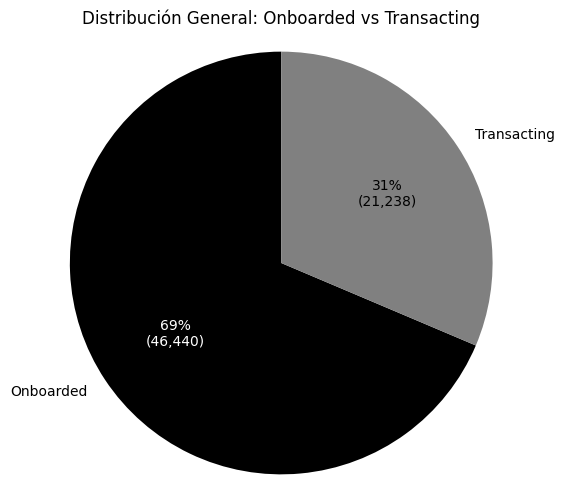

In [34]:
import matplotlib.pyplot as plt

# --- 1) Conteo global
counts = df['Transacting'].value_counts(dropna=False)

# --- 2) Mapear etiquetas
labels = ['Onboarded', 'Transacting']
sizes = [counts.get(0,0), counts.get(1,0)]
colors = ['black','grey']

# --- 3) Función para mostrar % y número absoluto
def autopct_format(pct, all_vals):
    total = sum(all_vals)
    val = int(round(pct*total/100.0))
    return f"{pct:.0f}%\n({val:,})"

# --- 4) Gráfico circular
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: autopct_format(pct, sizes),
    startangle=90,
    colors=colors,
    textprops={'color':'black'}  # color por defecto
)

# --- 5) Ajustar colores de texto para Onboarded (negro -> texto blanco)
for i, w in enumerate(wedges):
    if colors[i] == 'black':   # sector negro
        autotexts[i].set_color('white')  # % y número en blanco
        texts[i].set_color('black')      # etiqueta en blanco también (opcional)

ax.axis('equal')  # círculo perfecto
plt.title("Distribución General: Onboarded vs Transacting")
plt.show()



/tmp/ipython-input-3475067095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YMD'] = pd.to_datetime(df['YMD'], errors='coerce')
/tmp/ipython-input-3475067095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['YMD'].dt.to_period('M').astype(str)


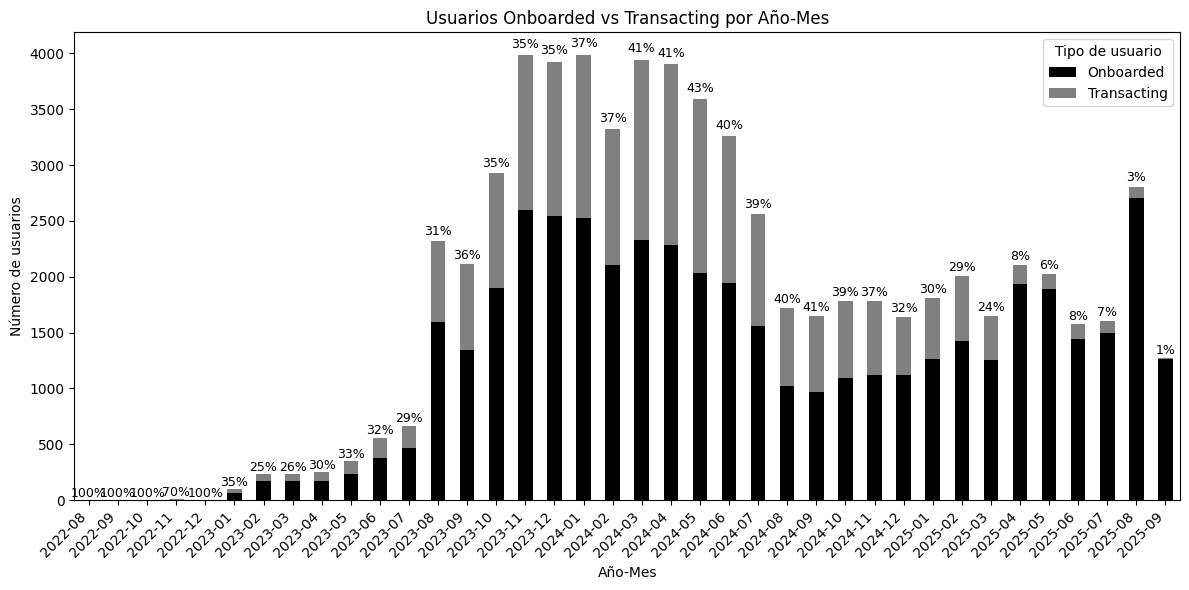

In [29]:


# --- 1) Asegura que la columna YMD sea datetime
df['YMD'] = pd.to_datetime(df['YMD'], errors='coerce')

# --- 2) Crea columna Año-Mes (YYYY-MM)
df['year_month'] = df['YMD'].dt.to_period('M').astype(str)

# --- 3) Agrupa por mes y Transacting
counts = (df.groupby(['year_month','Transacting'])
            .size()
            .reset_index(name='n_usuarios'))

# --- 4) Pivot para graficar
pivot = counts.pivot(index='year_month', columns='Transacting', values='n_usuarios').fillna(0)
pivot.columns = ['Onboarded','Transacting']

# --- 5) % transaccionales
pivot['% Transacting'] = (pivot['Transacting'] / (pivot['Onboarded'] + pivot['Transacting'])) * 100

# --- 6) Gráfico de barras apiladas
ax = pivot[['Onboarded','Transacting']].plot(
    kind='bar', stacked=True, figsize=(12,6),
    color=['black','grey']
)

# --- 7) Agregar etiquetas de % (redondeado a 0 decimales)
for idx, (onb, tra, pct) in enumerate(zip(pivot['Onboarded'], pivot['Transacting'], pivot['% Transacting'])):
    total = onb + tra
    if total > 0:
        ax.text(
            idx, total + total*0.01,
            f"{pct:.0f}%",          # ← redondeado a enteros
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

# --- 8) Detalles del gráfico
plt.title("Usuarios Onboarded vs Transacting por Año-Mes")
plt.xlabel("Año-Mes")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Tipo de usuario")
plt.tight_layout()
plt.show()


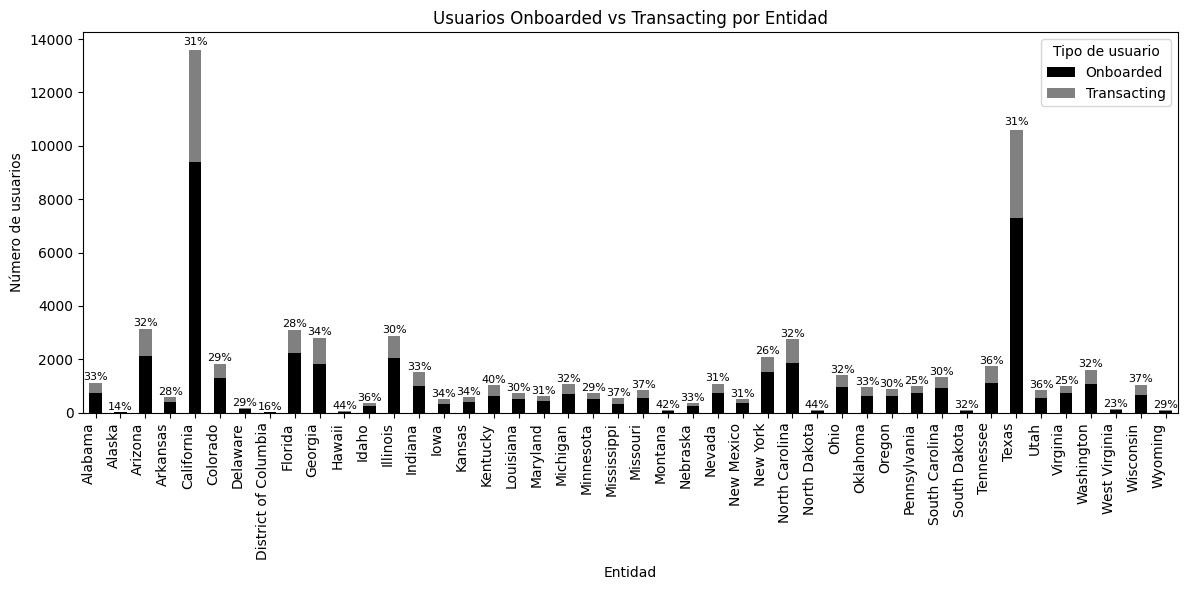

In [26]:


# --- 3) Agrupa por estado y Transacting
counts = (df.groupby(['state_name','Transacting'])
            .size()
            .reset_index(name='n_usuarios'))

# --- 4) Pivot para graficar
pivot = counts.pivot(index='state_name', columns='Transacting', values='n_usuarios').fillna(0)
pivot.columns = ['Onboarded','Transacting']

# --- 5) Calcula % transacting por estado
pivot['% Transacting'] = (pivot['Transacting'] / (pivot['Onboarded'] + pivot['Transacting'])) * 100

# --- 6) Gráfico de barras apiladas
ax = pivot[['Onboarded','Transacting']].plot(
    kind='bar', stacked=True, figsize=(12,6),
    color=['black','grey']
)

# --- 7) Agregar etiquetas de % arriba de cada barra
for idx, (onb, tra, pct) in enumerate(zip(pivot['Onboarded'], pivot['Transacting'], pivot['% Transacting'])):
    total = onb + tra
    if total > 0:
        ax.text(
            idx, total + total*0.01,    # posición arriba de la barra
            f"{pct:.0f}%",              # ← redondeado a 0 decimales
            ha='center', va='bottom',
            fontsize=8, color='black'
        )

# --- 8) Detalles del gráfico
plt.title("Usuarios Onboarded vs Transacting por Entidad")
plt.xlabel("Entidad")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=90, ha='right')
plt.legend(title="Tipo de usuario")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2526055335.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (df_age.groupby(['RangoEdad','Transacting'])


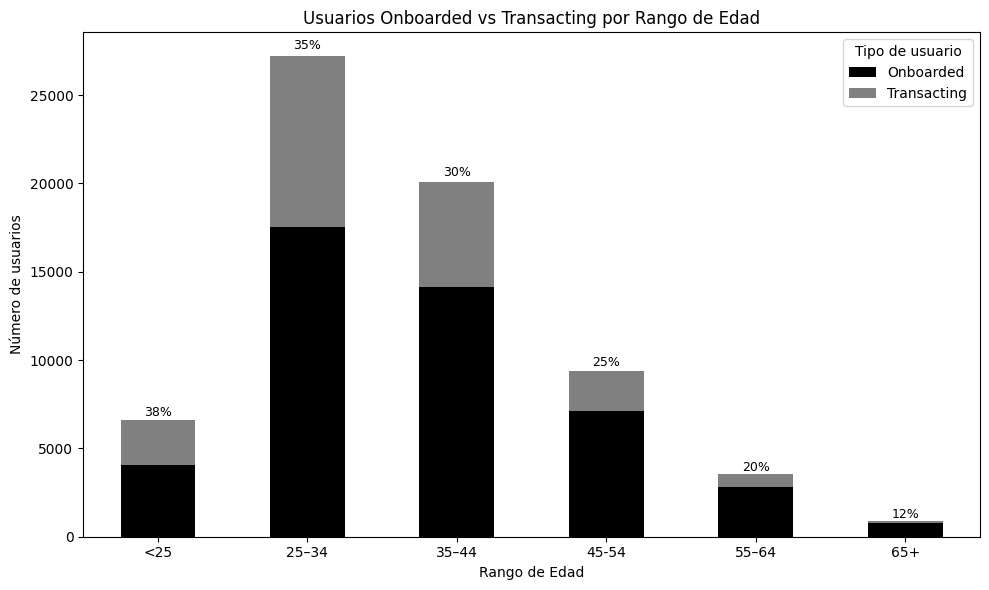

In [23]:

# --- 1) Año actual
year_now = pd.Timestamp.now().year

# --- 2) Calcular edad y filtrar outliers
df_age = df.copy()
df_age['Edad'] = year_now - df_age['YearOfBirth']
df_age = df_age[df_age['YearOfBirth'] != 1900]  # excluir outlier

# --- 3) Definir rangos de edad
bins = [0, 24, 34, 44, 54,64, 120]  # puedes ajustar el último valor
labels = ['<25','25–34','35–44','45-54','55–64','65+']
df_age['RangoEdad'] = pd.cut(df_age['Edad'], bins=bins, labels=labels, right=True)

# --- 4) Agrupar por rango de edad y Transacting
counts = (df_age.groupby(['RangoEdad','Transacting'])
                  .size()
                  .reset_index(name='n_usuarios'))

# --- 5) Pivot para gráfico
pivot = counts.pivot(index='RangoEdad', columns='Transacting', values='n_usuarios').fillna(0)
pivot.columns = ['Onboarded','Transacting']

# --- 6) % transaccionales
pivot['% Transacting'] = (pivot['Transacting'] / (pivot['Onboarded'] + pivot['Transacting'])) * 100

# --- 7) Gráfico apilado
ax = pivot[['Onboarded','Transacting']].plot(
    kind='bar', stacked=True, figsize=(10,6),
    color=['black','grey']
)

# --- 8) Etiquetas con % (redondeado a 0 decimales)
for idx, (onb, tra, pct) in enumerate(zip(pivot['Onboarded'], pivot['Transacting'], pivot['% Transacting'])):
    total = onb + tra
    if total > 0:
        ax.text(
            idx, total + total*0.01,
            f"{pct:.0f}%",
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

# --- 9) Detalles
plt.title("Usuarios Onboarded vs Transacting por Rango de Edad")
plt.xlabel("Rango de Edad")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=0)
plt.legend(title="Tipo de usuario")
plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

cols = ['Plaid', 'Pmt_method', 'Issued_Card','HaveSSN']
matrices = {}

for col in cols:
    if col in df.columns:
        # tabla cruzada: filas = valores de la columna, columnas = Transacting (0/1)
        ct = pd.crosstab(df[col], df['Transacting'], dropna=False)
        ct.columns = [f"Transacting={c}" for c in ct.columns]  # renombrar columnas
        ct['Total'] = ct.sum(axis=1)
        ct['% Transacting=1'] = (ct['Transacting=1.0'] / ct['Total'] * 100).round(2)
        matrices[col] = ct

# Ahora puedes revisar cada tabla:
for col, tabla in matrices.items():
    print(f"\n=== {col} ===")
    display(tabla)


=== Plaid ===


,Transacting=0.0,Transacting=1.0,Total,% Transacting=1
Plaid,,,,
0.0,45891,18920,64811,29.19
1.0,549,2318,2867,80.85



=== Pmt_method ===


,Transacting=0.0,Transacting=1.0,Total,% Transacting=1
Pmt_method,,,,
0.0,44839,13860,58699,23.61
1.0,1601,7378,8979,82.17



=== Issued_Card ===


,Transacting=0.0,Transacting=1.0,Total,% Transacting=1
Issued_Card,,,,
0.0,24649,1824,26473,6.89
1.0,21791,19414,41205,47.12



=== HaveSSN ===


,Transacting=0.0,Transacting=1.0,Total,% Transacting=1
HaveSSN,,,,
No,39121,17955,57076,31.46
Yes,7319,3283,10602,30.97
